# Stock Price Prediction for New York Stock Exchange

## Preprocessing of the dataset

### Loading the Libraries and datasets

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data = pd.read_csv('nyse/prices-split-adjusted.csv')


In [3]:
data_1 = data[data['symbol'] == 'WLTW'][['date', 'open', 'close', 'low', 'high', 'volume']]
data_1.head()

,date,open,close,low,high,volume
0,2016-01-05,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
data_1.dtypes

date       object
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

### As our data is not in datetime format, lets convert it to datetime

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('nyse/prices-split-adjusted.csv', parse_dates=['date'], index_col= 'date',date_parser=dateparse)
data_1 = data[data['symbol'] == 'WLTW'][['open', 'close', 'low', 'high', 'volume']]
data_1.head()

,open,close,low,high,volume
date,,,,,
2016-01-05,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,117.010002,114.970001,114.089996,117.330002,1408600.0


In [6]:
data_1.dtypes

open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

### Now the date format is in datetime , so we can convert the dataset in timeseries and play along

In [7]:
data_open = data_1['close']
data_open.head()

date
2016-01-05    125.839996
2016-01-06    119.980003
2016-01-07    114.949997
2016-01-08    116.620003
2016-01-11    114.970001
Name: close, dtype: float64

### Lets retrieve some close index by giving the time as an input

In [8]:
data_open['2016-01-01' : '2016-01-31'] #stock price for the month of jaunary

date
2016-01-05    125.839996
2016-01-06    119.980003
2016-01-07    114.949997
2016-01-08    116.620003
2016-01-11    114.970001
2016-01-12    115.550003
2016-01-13    112.849998
2016-01-14    114.379997
2016-01-15    112.529999
2016-01-19    110.379997
2016-01-20    109.300003
2016-01-21    110.000000
2016-01-22    111.949997
2016-01-25    110.120003
2016-01-26    111.000000
2016-01-27    110.709999
2016-01-28    112.580002
2016-01-29    114.470001
Name: close, dtype: float64

## Lets check the stationarity of time series data_open
There are three methods to check the stationarity:
1. By Visually looking at the plots
2. Summary Statistics --> to check the seasons and partition of the dataset
3. Statistical Test --> which tells if there is any violation of the stationarity of the series

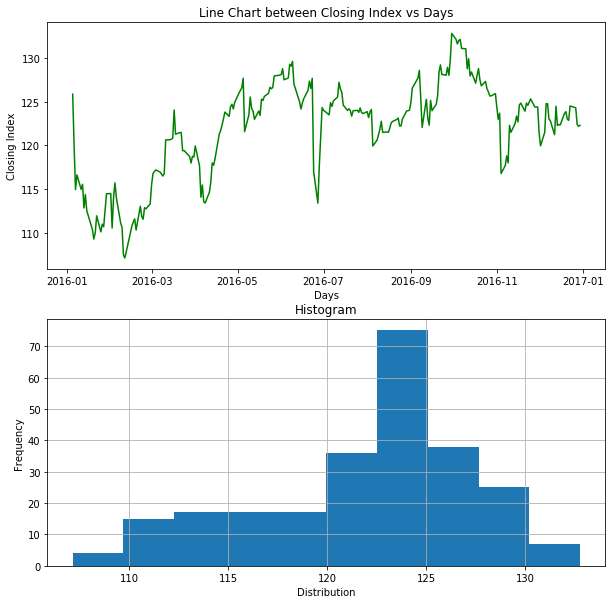

In [40]:
f = plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(data_open, color = 'green') #Visually looking at the plots and determine that series is not stationary
plt.xlabel('Days')
plt.ylabel('Closing Index')
plt.title('Line Chart between Closing Index vs Days')
plt.subplot(2, 1, 2)
data_open.hist()
plt.xlabel('Distribution')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [10]:
def statistics_check(series):
    values = series
    split = int(len(values)/2)
    data_open_1, data_open_2 = values[0:split], values[split+1:]
    mean1, mean2 = data_open_1.mean(), data_open_2.mean()
    variance1, variance2 = data_open_1.var(), data_open_2.var()
    print('mean1=',mean1, ", mean2=",mean2)
    print('variance1=',variance1, ", variance2=",variance2)

In [11]:
#statistics by checking the mean and variance by splitting the data
statistics_check(data_open.values)

mean1= 119.357360152 , mean2= 124.596639568
variance1= 36.2052312261 , variance2= 8.98625177998


#### By seeing the difference between mean and variance we can say its not stationary, lets proceed with Dickey-Fuller Test to confirm this

### Dickey-Fuller test
This test will give us ADF, P-value and critical values, if test rejects the null hypothesis then series is not stationary and if it failed to reject it then it is stationary

In [12]:
def dickey_Fuller(series):
    result_adFuller = adfuller(series)
    print('ADF-Statistics:',result_adFuller[0])
    print('P-value:',result_adFuller[1])
    print('Critical Values:')
    for key,value in result_adFuller[4].items():
        print(key, ':', value)

In [13]:
dickey_Fuller(data_open.values)

ADF-Statistics: -2.64002817508
P-value: 0.0850031929154
Critical Values:
1% : -3.45678085971
5% : -2.87317150656
10% : -2.572968544


### As p-value is 0.08 which signifies that it failed to reject the null hypothesis, that means it is not stationary

## Convert the non stationary time-series to stationary time series
There are two ways to convert the non stationary time-series to stationary time series
1. Differencing
2. Transformation eg log, exponential

mean1= -0.018879944 , mean2= -0.0208871290323
variance1= 4.06299003557 , variance2= 2.14243662818
ADF-Statistics: -9.55376589278
P-value: 2.53086820874e-16
Critical Values:
1% : -3.45721523727
5% : -2.87336184157
10% : -2.57307007601


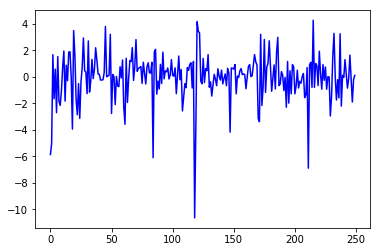

In [41]:
#Lets check with differencing and check the stationary using above approach
first_diff = np.diff(data_open)
plt.plot(first_diff, color = 'blue')
statistics_check(first_diff)
dickey_Fuller(first_diff)

### According to stationarity test we can say our series is stationary now as difference between mean is very small and p-value is negligible

mean1= 0.043064483871 , mean2= -0.0103225725806
variance1= 7.44157958946 , variance2= 4.94482738905
ADF-Statistics: -9.39228253147
P-value: 6.51249391689e-16
Critical Values:
1% : -3.45789425297
5% : -2.87365932002
10% : -2.57322876736


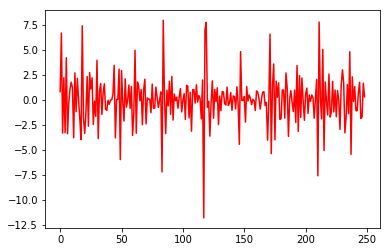

In [42]:
#Lets check with double differencing and check the stationary using above approach
second_diff = np.diff(np.diff(data_open))
plt.plot(second_diff, color = 'red')
statistics_check(second_diff)
dickey_Fuller(second_diff)

mean1= 4.780842874743766 , mean2= 4.824794260350212
variance1= 0.0025877880431240913 , variance2= 0.0005774330126954057
ADF-Statistics: -2.62709786999
P-value: 0.0875250131431
Critical Values:
1% : -3.45678085971
5% : -2.87317150656
10% : -2.572968544


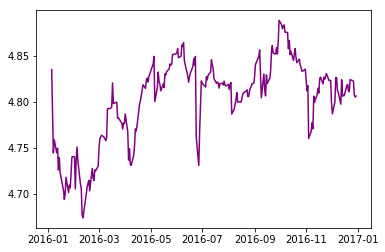

In [43]:
#log transformation
log_transform = np.log(data_open)
plt.plot(log_transform, color = 'purple')
statistics_check(log_transform)
dickey_Fuller(log_transform)

### First Differencing is doing better job than Second level of differencing and log transformation

## Building a model to forecast the time series 

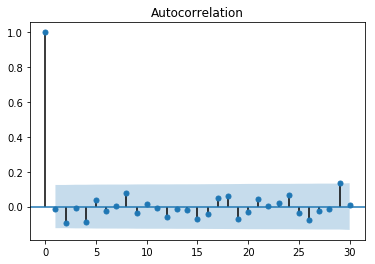

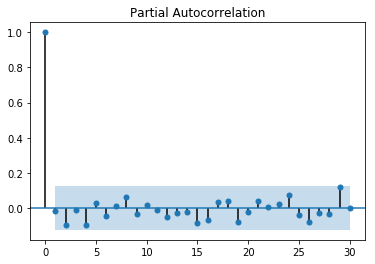

In [45]:
data_acf_1 = plot_acf(first_diff, lags = 30)
data_acf_2 = plot_pacf(first_diff, lags = 30)

#### By these plots we find AR value should be 1, differencing level is 1 and MA value should also be 1

### AR Model

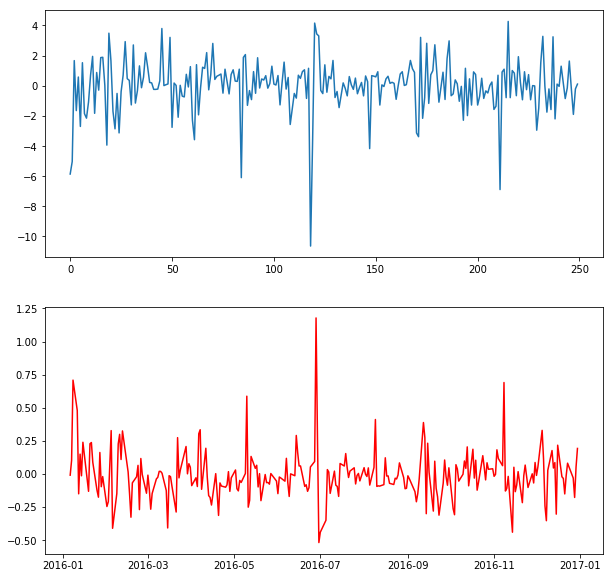

In [82]:
model = ARIMA(data_open, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
f = plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(first_diff, label = 'original')
plt.subplot(2, 1, 2)
plt.plot(results_AR.fittedvalues, color='red', label = 'predicted')
plt.show()

### RA Model

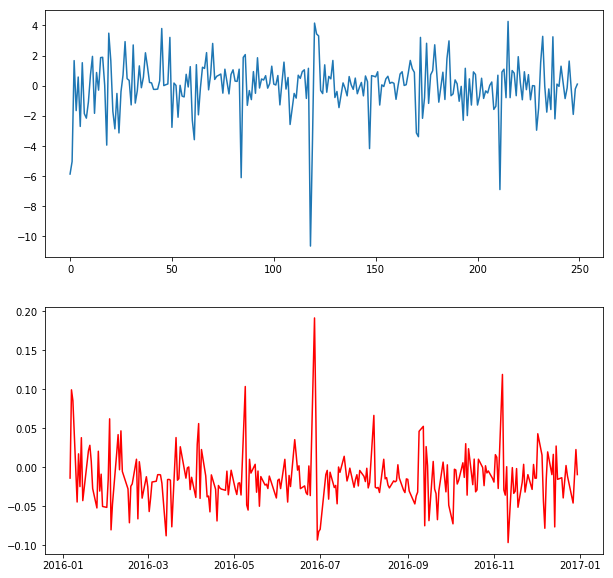

In [77]:
model = ARIMA(data_open, order=(0, 1, 1))  
results_AR = model.fit(disp=-1)  
f = plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(first_diff, label = 'original')
plt.subplot(2, 1, 2)
plt.plot(results_AR.fittedvalues, color='red', label = 'predicted')
plt.show()

### ARIMA Model

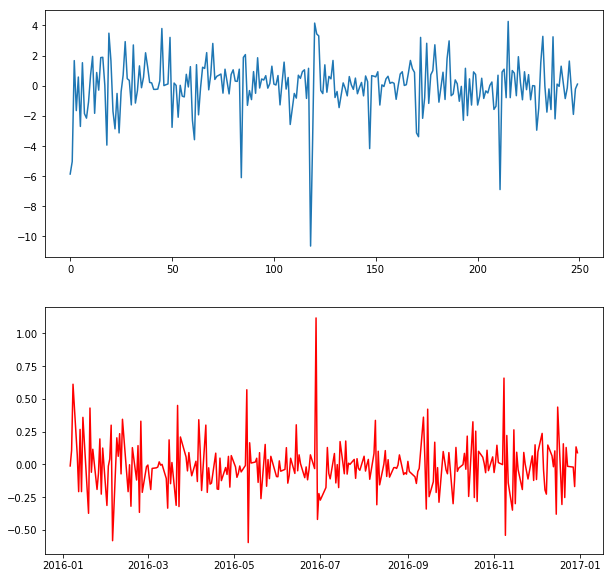

In [81]:
model = ARIMA(data_open, order=(2, 1, 1))  
results_AR = model.fit(disp=-1)  
f = plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(first_diff, label = 'original')
plt.subplot(2, 1, 2)
plt.plot(results_AR.fittedvalues, color='red', label = 'predicted')
plt.show()